In [27]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [28]:
nombre_csv=1
df= pd.read_csv(f'Data1_actividad/{nombre_csv}.csv')
df

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2
0,2024-01-01,0,0.079,0.0,0.410,0.511,1.0,0.0,4.0,2.0,-0.209528,-1.025107
1,2024-01-01,1,0.000,0.0,0.652,0.348,0.0,0.0,1.0,1.0,-0.327217,-0.443815
2,2024-01-01,2,0.000,0.0,0.443,0.557,0.0,0.0,1.0,1.0,-0.249102,-0.443815
3,2024-01-01,3,0.000,0.0,0.462,0.538,0.0,0.0,2.0,2.0,-0.256203,-0.887631
4,2024-01-01,4,0.000,0.0,0.711,0.289,0.0,0.0,1.0,1.0,-0.349269,-0.443815
...,...,...,...,...,...,...,...,...,...,...,...,...
3931,2024-06-30,19,1.000,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.261279,0.200319
3932,2024-06-30,20,0.341,0.0,0.000,0.659,1.0,0.0,0.0,1.0,0.034052,-0.074599
3933,2024-06-30,21,0.000,0.0,0.551,0.449,0.0,0.0,1.0,2.0,-0.289468,-0.718734
3934,2024-06-30,22,0.416,0.0,0.000,0.584,1.0,0.0,0.0,1.0,0.059913,-0.074599


# Aplicacion de cliclo circadiano

In [29]:
df_c = df
# Convertir 'Fecha' y 'Hora' a datetime
df_c['datetime'] = pd.to_datetime(df_c['Fecha'] + ' ' + df_c['Hora'].astype(str) + ':00:00')
df_c = df_c.set_index('datetime')
df_c = df_c.sort_index()

# Función para calcular la Transformada de Fourier y extraer el ciclo circadiano
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar frecuencias cercanas a 1 ciclo por día
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
    
    # Reconstruir la señal
    return np.real(np.fft.ifft(fft_filtered))

# Función para procesar un tipo de actividad
def process_activity(df_c, activity_column):
    # Calcular el ciclo circadiano para cada día
    daily_cycles = {}
    for date, group in df_c.groupby(df_c.index.date):
        if len(group) == 24:  # Asegurarse de que hay 24 horas de datos
            daily_cycles[date] = extract_circadian_cycle(group[activity_column].values)

    # Calcular el ciclo circadiano promedio
    average_cycle = np.mean(list(daily_cycles.values()), axis=0)

    # Calcular la distancia absoluta entre cada hora del ciclo promedio y cada día
    hourly_distances = []
    for date, cycle in daily_cycles.items():
        for hour in range(24):
            hourly_distances.append({
                'Fecha': date,
                'Hora': hour,
                'distancia': abs(average_cycle[hour] - cycle[hour])
            })

    # Convertir las distancias horarias a un DataFrame
    distance_df = pd.DataFrame(hourly_distances)
    # Calcular los umbrales para los niveles de estrés
    min_distance = distance_df['distancia'].min()
    max_distance = distance_df['distancia'].max()
    threshold1 = min_distance + (max_distance - min_distance) / 2
    #threshold2 = min_distance + 2 * (max_distance - min_distance) / 4
    threshold2 = threshold1 + (max_distance - threshold1) /2
    threshold3 = max_distance
    # Calcular los umbrales usando cuantiles
    #threshold2 = distance_df['distancia'].quantile(0.75)  # Cuantil 75% (Q3)
    #threshold1 = distance_df['distancia'].quantile(0.50)  # Cuantil 50% (Q2)
    # Función para determinar el nivel de estrés
    def get_stress_level(distance):
        if distance <= threshold1:
            return 'normal'
        elif distance <= threshold2:
            return 'alerta'
        else:
            return 'peligro'

    # Aplicar la función a las distancias y crear una columna de niveles de estrés
    distance_df['stress_level'] = distance_df['distancia'].apply(get_stress_level)
    
    return distance_df[['Fecha', 'Hora', 'stress_level']]

# Procesar ambas columnas de actividad
stress_levels_1 = process_activity(df_c, 'activity_level')
stress_levels_2 = process_activity(df_c, 'activity_level_2')

# Renombrar las columnas para diferenciar los niveles de estrés
stress_levels_1 = stress_levels_1.rename(columns={'stress_level': 'stress_level_1'})
stress_levels_2 = stress_levels_2.rename(columns={'stress_level': 'stress_level_2'})

# Preparar los DataFrames para la fusión
df['Fecha'] = pd.to_datetime(df['Fecha'])
stress_levels_1['Fecha'] = pd.to_datetime(stress_levels_1['Fecha'])
stress_levels_2['Fecha'] = pd.to_datetime(stress_levels_2['Fecha'])
df['Hora'] = df['Hora'].astype(int)
stress_levels_1['Hora'] = stress_levels_1['Hora'].astype(int)
stress_levels_2['Hora'] = stress_levels_2['Hora'].astype(int)

# Combinar todos los DataFrames
df_final = df.merge(stress_levels_1, on=['Fecha', 'Hora'], how='left')
df_final = df_final.merge(stress_levels_2, on=['Fecha', 'Hora'], how='left')

# El resultado final está en df_final
df_final

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2,datetime,stress_level_1,stress_level_2
0,2024-01-01,0,0.079,0.0,0.410,0.511,1.0,0.0,4.0,2.0,-0.209528,-1.025107,2024-01-01 00:00:00,normal,normal
1,2024-01-01,1,0.000,0.0,0.652,0.348,0.0,0.0,1.0,1.0,-0.327217,-0.443815,2024-01-01 01:00:00,normal,normal
2,2024-01-01,2,0.000,0.0,0.443,0.557,0.0,0.0,1.0,1.0,-0.249102,-0.443815,2024-01-01 02:00:00,normal,normal
3,2024-01-01,3,0.000,0.0,0.462,0.538,0.0,0.0,2.0,2.0,-0.256203,-0.887631,2024-01-01 03:00:00,normal,normal
4,2024-01-01,4,0.000,0.0,0.711,0.289,0.0,0.0,1.0,1.0,-0.349269,-0.443815,2024-01-01 04:00:00,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,2024-06-30,19,1.000,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.261279,0.200319,2024-06-30 19:00:00,normal,normal
3932,2024-06-30,20,0.341,0.0,0.000,0.659,1.0,0.0,0.0,1.0,0.034052,-0.074599,2024-06-30 20:00:00,normal,normal
3933,2024-06-30,21,0.000,0.0,0.551,0.449,0.0,0.0,1.0,2.0,-0.289468,-0.718734,2024-06-30 21:00:00,alerta,normal
3934,2024-06-30,22,0.416,0.0,0.000,0.584,1.0,0.0,0.0,1.0,0.059913,-0.074599,2024-06-30 22:00:00,alerta,normal


# grafica

In [30]:
nombre_csv=1
df= pd.read_csv(f'Data1_actividad/{nombre_csv}.csv')
df

df_c2 = df

# Convertir 'Fecha' y 'Hora' a datetime
df_c2['datetime'] = pd.to_datetime(df_c2['Fecha'] + ' ' + df_c2['Hora'].astype(str) + ':00:00')
df_c2 = df_c2.set_index('datetime')
df_c2 = df_c2.sort_index()

# Función para calcular la Transformada de Fourier y extraer el ciclo circadiano
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar frecuencias cercanas a 1 ciclo por día
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
    
    # Reconstruir la señal
    return np.real(np.fft.ifft(fft_filtered))

# Calcular el ciclo circadiano para cada día en activity_level y activity_level_2
daily_cycles = {'activity_level': {}, 'activity_level_2': {}}
for date, group in df_c2.groupby(df_c2.index.date):
    if len(group) == 24:  # Asegurarse de que hay 24 horas de datos
        daily_cycles['activity_level'][date] = extract_circadian_cycle(group['activity_level'].values)
        daily_cycles['activity_level_2'][date] = extract_circadian_cycle(group['activity_level_2'].values)

# Calcular los ciclos circadianos promedio
average_cycle = {
    'activity_level': np.mean(list(daily_cycles['activity_level'].values()), axis=0),
    'activity_level_2': np.mean(list(daily_cycles['activity_level_2'].values()), axis=0)
}

# Calcular la distancia absoluta entre cada hora del ciclo promedio y cada día
hourly_distances = []
for date, cycle1 in daily_cycles['activity_level'].items():
    cycle2 = daily_cycles['activity_level_2'][date]
    for hour in range(24):
        hourly_distances.append({
            'Fecha': date,
            'Hora': hour,
            'distancia_activity_level': abs(average_cycle['activity_level'][hour] - cycle1[hour]),
            'distancia_activity_level_2': abs(average_cycle['activity_level_2'][hour] - cycle2[hour])
        })

# Convertir las distancias horarias a un DataFrame
distance_df = pd.DataFrame(hourly_distances)

# Calcular los umbrales para los niveles de estrés
min_distance_1 = distance_df['distancia_activity_level'].min()
max_distance_1 = distance_df['distancia_activity_level'].max()
threshold1_1 = min_distance_1+ (max_distance_1 - min_distance_1) / 2
threshold2_1 = threshold1_1 + (max_distance_1 - threshold1_1) /2
threshold3_1 = max_distance_1

min_distance_2 = distance_df['distancia_activity_level_2'].min()
max_distance_2 = distance_df['distancia_activity_level_2'].max()
threshold1_2 = min_distance_2 + (max_distance_2 - min_distance_2) / 2
threshold2_2 = threshold1_2 + (max_distance_2 - threshold1_2) /2
threshold3_2 = max_distance_2

# Calcular los umbrales como el percentil 75 (cuantil 3) y el percentil 50 (cuantil 2) para ambos niveles de actividad
#threshold1_1 = distance_df['distancia_activity_level'].quantile(0.75)  # percentil 75 para activity_level
#threshold2_1 = distance_df['distancia_activity_level'].quantile(0.5)   # percentil 50 para activity_level
#threshold3_1 = distance_df['distancia_activity_level'].quantile(1.0)   # percentil 100 para activity_level
#threshold1_2 = distance_df['distancia_activity_level_2'].quantile(0.75)  # percentil 75 para activity_level_2
#threshold2_2 = distance_df['distancia_activity_level_2'].quantile(0.5)   # percentil 50 para activity_level_2
#threshold3_2 = distance_df['distancia_activity_level_2'].quantile(1.0)   # percentil 50 para activity_level_2

# Función para determinar el nivel de estrés
def get_stress_level(distance, threshold1, threshold2):
    if distance <= threshold1:
        return 'normal'
    elif distance <= threshold2:
        return 'alerta'
    else:
        return 'peligro'

# Aplicar la función a las distancias y crear columnas de niveles de estrés
distance_df['stress_level'] = distance_df['distancia_activity_level'].apply(lambda x: get_stress_level(x, threshold1_1, threshold2_1))
distance_df['stress_level_2'] = distance_df['distancia_activity_level_2'].apply(lambda x: get_stress_level(x, threshold1_2, threshold2_2))

# Convertir fechas en ambos DataFrames para combinar
df['Fecha'] = pd.to_datetime(df['Fecha'])
distance_df['Fecha'] = pd.to_datetime(distance_df['Fecha'])
df['Hora'] = df['Hora'].astype(int)
distance_df['Hora'] = distance_df['Hora'].astype(int)

# Combinar el DataFrame original con los niveles de estrés
df = df.merge(distance_df[['Fecha', 'Hora', 'stress_level', 'stress_level_2']], on=['Fecha', 'Hora'], how='left')

df


,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2,datetime,stress_level,stress_level_2
0,2024-01-01,0,0.079,0.0,0.410,0.511,1.0,0.0,4.0,2.0,-0.209528,-1.025107,2024-01-01 00:00:00,normal,normal
1,2024-01-01,1,0.000,0.0,0.652,0.348,0.0,0.0,1.0,1.0,-0.327217,-0.443815,2024-01-01 01:00:00,normal,normal
2,2024-01-01,2,0.000,0.0,0.443,0.557,0.0,0.0,1.0,1.0,-0.249102,-0.443815,2024-01-01 02:00:00,normal,normal
3,2024-01-01,3,0.000,0.0,0.462,0.538,0.0,0.0,2.0,2.0,-0.256203,-0.887631,2024-01-01 03:00:00,normal,normal
4,2024-01-01,4,0.000,0.0,0.711,0.289,0.0,0.0,1.0,1.0,-0.349269,-0.443815,2024-01-01 04:00:00,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,2024-06-30,19,1.000,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.261279,0.200319,2024-06-30 19:00:00,normal,normal
3932,2024-06-30,20,0.341,0.0,0.000,0.659,1.0,0.0,0.0,1.0,0.034052,-0.074599,2024-06-30 20:00:00,normal,normal
3933,2024-06-30,21,0.000,0.0,0.551,0.449,0.0,0.0,1.0,2.0,-0.289468,-0.718734,2024-06-30 21:00:00,alerta,normal
3934,2024-06-30,22,0.416,0.0,0.000,0.584,1.0,0.0,0.0,1.0,0.059913,-0.074599,2024-06-30 22:00:00,alerta,normal


C:\Users\PC\AppData\Local\Temp\ipykernel_24508\800675728.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


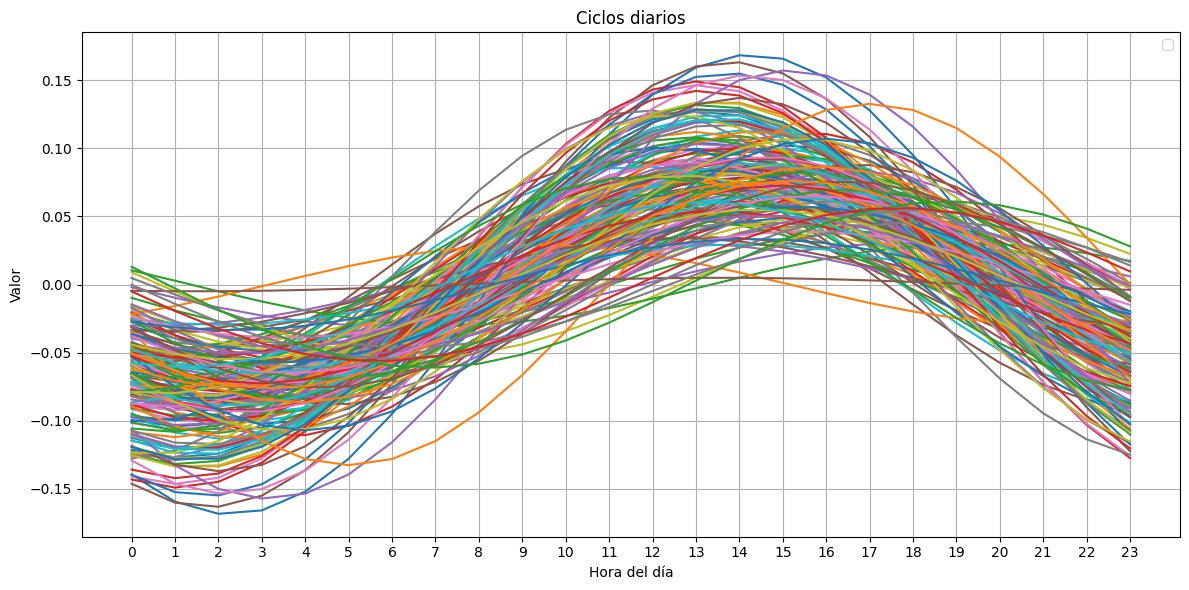

In [31]:
# Asumiendo que ya tienes tu diccionario daily_cycles

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada día
for date, values in daily_cycles['activity_level'].items():
    ax.plot(range(24), values)

# Configurar el eje x
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel('Hora del día')

# Configurar el eje y
ax.set_ylabel('Valor')

# Añadir título y leyenda
ax.set_title('Ciclos diarios')
ax.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
#plt.savefig(f'../Ciclos circadianos/{nombre_csv}_diario.png', format='png', dpi=300)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_24508\43506775.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


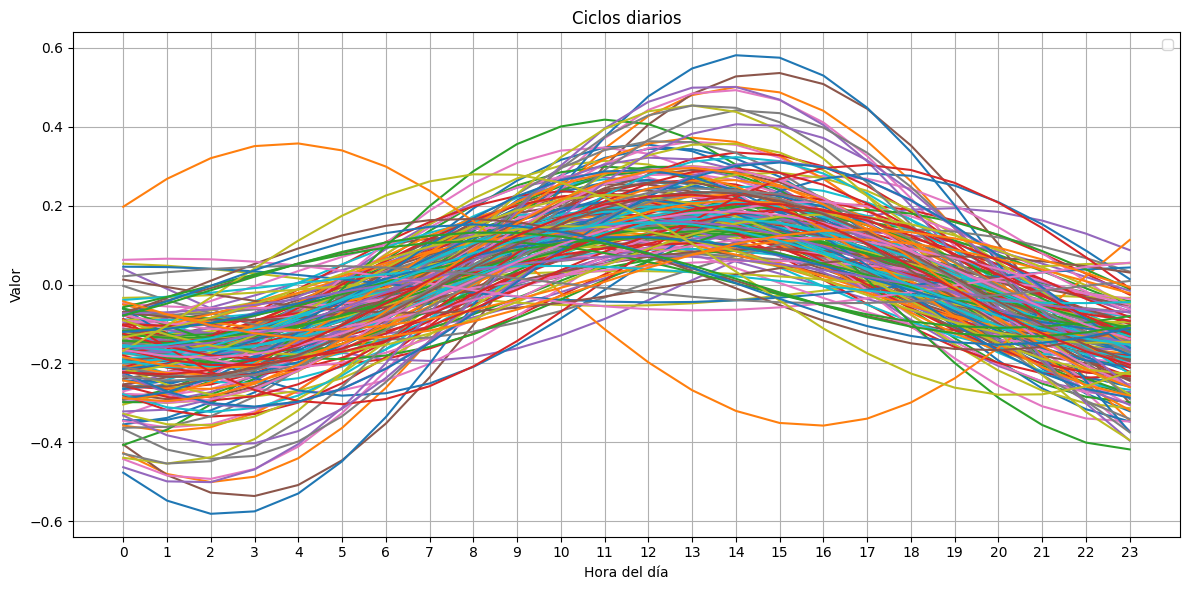

In [32]:

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada día
for date, values in daily_cycles['activity_level_2'].items():
    ax.plot(range(24), values)

# Configurar el eje x
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel('Hora del día')

# Configurar el eje y
ax.set_ylabel('Valor')

# Añadir título y leyenda
ax.set_title('Ciclos diarios')
ax.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
#plt.savefig(f'../Ciclos circadianos/{nombre_csv}_diario.png', format='png', dpi=300)
plt.show()

In [33]:
average_cycle['activity_level']

array([-0.06677612, -0.07530363, -0.07869933, -0.07673179, -0.06953512,
       -0.05759973, -0.04173902, -0.02303387, -0.002759  ,  0.0177039 ,
        0.0369603 ,  0.05369792,  0.06677612,  0.07530363,  0.07869933,
        0.07673179,  0.06953512,  0.05759973,  0.04173902,  0.02303387,
        0.002759  , -0.0177039 , -0.0369603 , -0.05369792])

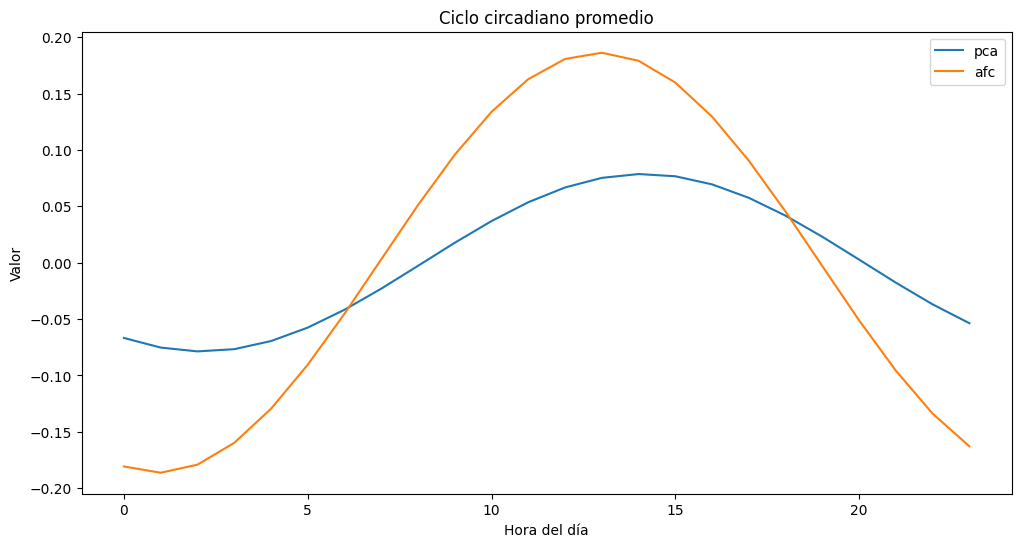

In [34]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
plt.plot(average_cycle['activity_level'], label='pca')
plt.plot(average_cycle['activity_level_2'], label='afc')
plt.title('Ciclo circadiano promedio')
plt.xlabel('Hora del día')
plt.ylabel('Valor')
plt.legend()
#plt.savefig(f'../Ciclos circadianos/{nombre_csv}_promedio.png', format='png', dpi=300)
plt.show()

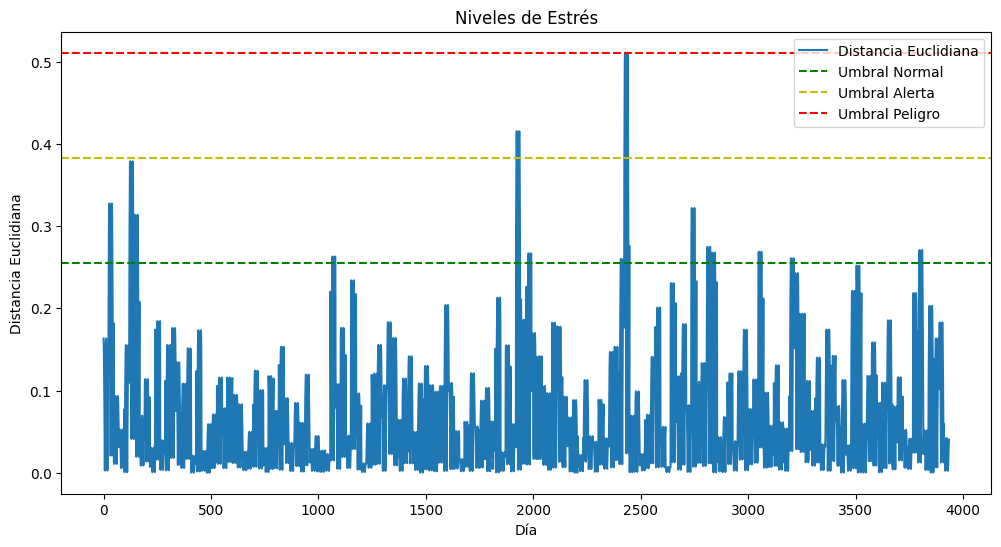

In [35]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
#plt.plot(distance_df['distancia_activity_level'], label='Distancia Euclidiana')
plt.plot(distance_df['distancia_activity_level_2'], label='Distancia Euclidiana')
plt.axhline(y=threshold1_2, color='g', linestyle='--', label='Umbral Normal')
plt.axhline(y=threshold2_2, color='y', linestyle='--', label='Umbral Alerta')
plt.axhline(y=threshold3_2, color='r', linestyle='--', label='Umbral Peligro')
plt.title('Niveles de Estrés')
plt.xlabel('Día')
plt.ylabel('Distancia Euclidiana')
plt.legend()
plt.show()

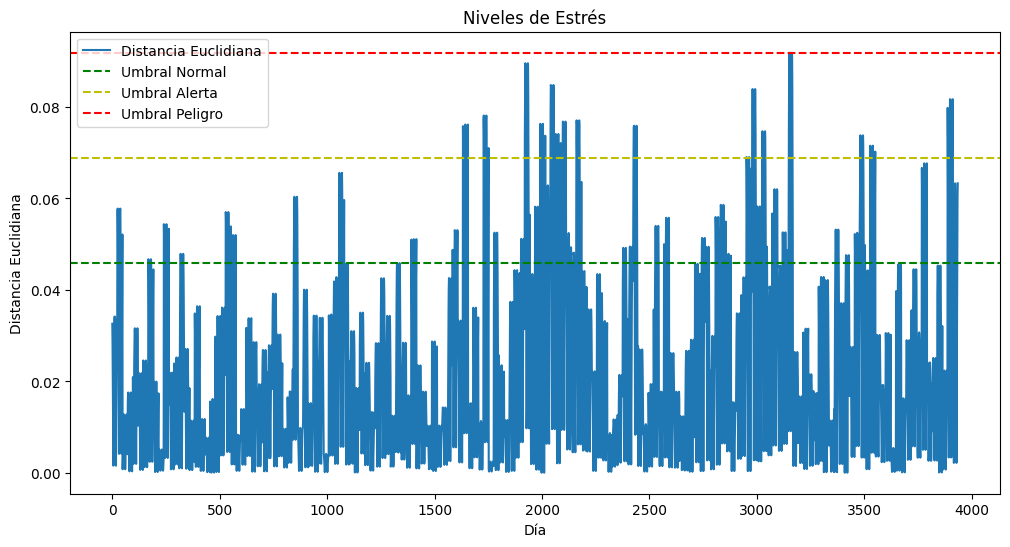

In [36]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
plt.plot(distance_df['distancia_activity_level'], label='Distancia Euclidiana')
#plt.plot(distance_df['distancia_activity_level_2'], label='Distancia Euclidiana')
plt.axhline(y=threshold1_1, color='g', linestyle='--', label='Umbral Normal')
plt.axhline(y=threshold2_1, color='y', linestyle='--', label='Umbral Alerta')
plt.axhline(y=threshold3_1, color='r', linestyle='--', label='Umbral Peligro')
plt.title('Niveles de Estrés')
plt.xlabel('Día')
plt.ylabel('Distancia Euclidiana')
plt.legend()
plt.show()

In [37]:
# Contar los niveles de estrés
print(df_final['stress_level_1'].value_counts())

stress_level_1
normal     3426
alerta      388
peligro     122
Name: count, dtype: int64


In [38]:
# Contar los niveles de estrés
print(df_final['stress_level_2'].value_counts())

stress_level_2
normal     3828
alerta       92
peligro      16
Name: count, dtype: int64


In [39]:
# Contar los niveles de estrés


print(df['stress_level'].value_counts())

stress_level
normal     3426
alerta      388
peligro     122
Name: count, dtype: int64


In [40]:
# Contar los niveles de estrés
print(df['stress_level_2'].value_counts())

stress_level_2
normal     3828
alerta       92
peligro      16
Name: count, dtype: int64
